# Data collection and statistics for relevant sentences
We want the final answer extractor to output answers and a set of sentences from the context that are relevant for the given question/answer pair. Thus, in the training data we want both the correct answer (which we have) and the set of sentences that are relevant for the answer. This notebook does two things:
1. For the given dataset, for each text-object it extracts the sentences that are relevant for the question/answer pair
    1. A sentence is deemed relevant if there is word overlap between the sentence and the answer/question.
    1. Possible to do some simpler inference here, to deem other sentences relevant (at a later stage)
1. Provide some statistics and categorization of the data, based on how many sentences are relevant to the quetion/answer

In [16]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords

In [67]:
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_dp_overlap_train = pd.read_pickle("./data_frames/dependency_parsing/df_dp_overlap_train.pkl")
df_dp_overlap_train.head()

,answer,answer_lemmas,answer_stop_lemmas,answer_words,answer_stop_words,answer_pos,answer_deprel,answer_root,answer_root_pos,sent_with_ans,...,word_stop_ans_wordcount,word_stop_q_wordcount,lemma_overlap_count,lemma_overlap_words,lemma_ans_wordcount,lemma_q_wordcount,lemma_stop_overlap_count,lemma_stop_overlap_words,lemma_stop_ans_wordcount,lemma_stop_q_wordcount
0,ett tillstånd för att resa in och vara i ett land,"[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]","[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[DET, NOUN, ADP, PART, VERB, ADV, CCONJ, AUX, ...","[det, root, mark, mark, advcl, compound:prt, c...",tillstånd,NOUN,visum är ett tillstånd för att resa in och var...,...,7,1,3,"[visum, vara, en]",14,4,1,[visum],7,1
1,ditt pass,"[du, pass]",[pass],"[ditt, pass]",[pass],"[PRON, NOUN]","[nmod:poss, root]",pass,NOUN,när du ska hämta ditt beslut ska du ta med dit...,...,5,4,7,"[när, du, skola, hämta, beslut, ta, med]",8,8,4,"[skola, hämta, beslut, ta]",5,4
2,ett år,"[en, år]",[år],"[ett, år]",[år],"[DET, NOUN]","[det, root]",år,NOUN,så länge gäller tillståndet ett uppehållstills...,...,12,5,7,"[länge, gälla, en, uppehållstillstånd, för, be...",18,8,4,"[länge, gälla, uppehållstillstånd, besök]",11,4
3,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,9,1,2,"[vara, en]",17,4,0,[],9,1
4,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,9,1,2,"[vara, en]",17,4,0,[],9,1


In [68]:
def find_missing_words(overlap_words, q_words):
    missing_words = []
    for q_w in q_words:
        if not q_w in overlap_words:
            missing_words.append(q_w)
    return missing_words
        

def check_overlap_class(overlap_words, q_words, s_words):
    # TODO: check that overlap words are the same as s_words!
    overlap = 0
    missing_words = []
    for word in q_words:
        if word in s_words:
            overlap += 1
        else:
           missing_words.append(word) 
    
    if overlap == len(q_words):
        return 1, []
    else:
        return 3, missing_words
    

In [69]:
# in the df_dp_train the columns q_words and sent_words holds the lemmatized words of the question and answer sentence.
# df_train['context_parsed_tok_lemma'] holds the tokenized, lemmatized contexts

def collect_relevant_sentences(df, df_dp, remove_stopwords=True, use_lemmas=False):
    all_relevant_sentences = []
    all_relevant_sentence_idxs = []
    for index, row in df_dp.iterrows():
        a_loc = df.iloc[index]['answer_location']
        # given parameters, get the column names from which to get the data
        df_dp_col = ''
        df_col = ''
        df_overlap_col = ''
        if remove_stopwords:
            df_dp_col = 'stop_'
            df_col = '_stop'
            df_overlap_col = '_stop'
        if use_lemmas:
            df_col = '_lemma'+df_col
            df_overlap_col = 'lemma'+df_overlap_col
            df_dp_col += 'lemmas'
        else:
            df_dp_col += 'words'
            df_overlap_col = 'word'+df_overlap_col

        q_w = row['q_'+df_dp_col]
        a_w = row['sent_'+df_dp_col]
        c_w = df.iloc[index]['context_parsed_tok'+df_col]

        # remove duplicate words
        q_w = list(dict.fromkeys(q_w))
        a_w = list(dict.fromkeys(a_w))
        c_w = [ list(dict.fromkeys(w)) for w in c_w ]

        relevant_sentences = {}
        overlap_class, missing_words_sent = check_overlap_class(c_w[a_loc], q_w, a_w)
        # always add the sentence where the answer is to the relevant sentences
        relevant_sentences[a_loc] = {'sentence_words': a_w, 'overlap_words': row[df_overlap_col+'_overlap_words'], 'overlap_count': row[df_overlap_col+'_overlap_count']}

        words_in_context = set()
        for c_idx, c_sent in enumerate(c_w):
            for word in q_w:
                if word in c_sent:
                    words_in_context.add(word)
                    if c_idx != a_loc and c_idx in relevant_sentences:
                        # this sentence has already been detected to include overlapping words!
                        if not word in relevant_sentences[c_idx]['overlap_words']:
                            relevant_sentences[c_idx]['overlap_words'].append(word)
                            relevant_sentences[c_idx]['overlap_count'] += 1
                    elif c_idx != a_loc:
                        relevant_sentences[c_idx] = {'sentence_words': c_sent, 'overlap_words': [word], 'overlap_count': 1}
        
        missing_words_context = []
        if overlap_class == 3:
            overlap_words = list(words_in_context)
            if len(overlap_words) == len(q_w):
                overlap_class = 2
            else:
                missing_words_context = find_missing_words(overlap_words, q_w)
            


        all_relevant_sentences.append({
            'context_'+df_dp_col: c_w, 'sent_'+df_dp_col: a_w, 'q_'+df_dp_col: q_w, 'overlap_class': overlap_class,
            'num_overlap_sentences': len(relevant_sentences), 'missing_words_sent': missing_words_sent,
            'missing_words_context': missing_words_context, 'matching_sentence_ids': relevant_sentences.keys(), 'data': relevant_sentences
            })
        all_relevant_sentence_idxs.append(relevant_sentences.keys())
    return all_relevant_sentences, all_relevant_sentence_idxs




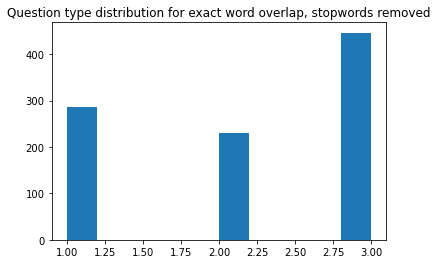

,context_stop_words,sent_stop_words,q_stop_words,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,data
1,"[[eget, företag], [efter, beslut, beslutet, sk...","[ska, hämta, beslut, ta, pass]","[ska, ta, hämtar, beslut]",3,4,[hämtar],[hämtar],"(2, 1, 9, 12)","{2: {'sentence_words': ['ska', 'hämta', 'beslu..."
10,"[[distributionselektriker], [utbildning, distr...","[vill, starta, eget, elinstallationsföretag, ,...","[måste, göra, starta, eget, elinstallationsför...",3,2,[göra],[göra],"(11, 9)","{11: {'sentence_words': ['vill', 'starta', 'eg..."
12,"[[andra, sorters, studier], [så, ansöker, du, ...","[kopior, sidor, pass, visar, personuppgifter, ...","[ska, kopiorna, sidor, pass, visa]",3,11,"[ska, kopiorna, visa]",[kopiorna],"(11, 2, 8, 9, 10, 12, 13, 14, 15, 16, 17)","{11: {'sentence_words': ['kopior', 'sidor', 'p..."
13,"[[volontärarbete, praktik], [om, vill, arbeta,...","[kopior, sidor, pass, visar, personuppgifter, ...","[ska, kopiorna, sidor, pass, visa]",3,7,"[ska, kopiorna, visa]","[kopiorna, visa]","(11, 3, 4, 5, 8, 10, 14)","{11: {'sentence_words': ['kopior', 'sidor', 'p..."
16,"[[tillgänglighetsperspektiv, arbetsmiljöverket...","[2016, 2017, genomfördes, tillsynsinsats, rubr...","[rubrik, tillsynsinstsen, genomfördes, 2016, 2...",3,2,"[rubrik, tillsynsinstsen]","[rubrik, tillsynsinstsen]","(10, 6)","{10: {'sentence_words': ['2016', '2017', 'geno..."


In [70]:
# word overlap with stopwords removed
all_relevant_sentences_word_stop, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train)
df_word_stop = pd.DataFrame(all_relevant_sentences_word_stop)

df_class_1 = df_word_stop.loc[df_word_stop['overlap_class'] == 1]
df_class_2 = df_word_stop.loc[df_word_stop['overlap_class'] == 2]
df_class_3 = df_word_stop.loc[df_word_stop['overlap_class'] == 3]

plt.hist(df_word_stop['overlap_class'].values)
plt.title('Question type distribution for exact word overlap, stopwords removed')
plt.show()
df_class_3.head()

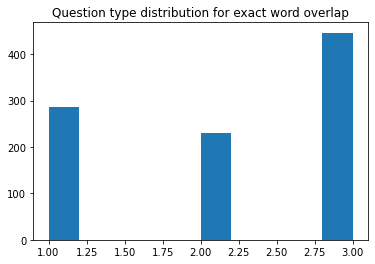

,context_words,sent_words,q_words,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,data
0,"[[visum, för, affärs-, och, konferensbesök], [...","[visum, är, ett, tillstånd, för, att, resa, in...","[vad, är, ett, visum]",2,9,[vad],[],"(2, 0, 1, 3, 6, 7, 13, 15, 17)","{2: {'sentence_words': ['visum', 'är', 'ett', ..."
2,"[[utbytesdoktorander, intervju], [du, kommer, ...","[så, länge, gäller, tillståndet, ett, uppehåll...","[hur, länge, gäller, ett, uppehållstillstånd, ...",2,12,[hur],[],"(18, 2, 3, 4, 5, 8, 10, 12, 17, 19, 22, 24)","{18: {'sentence_words': ['så', 'länge', 'gälle..."
14,"[[du, har, rätt, till, en, säker, arbetsdag], ...","[en, god, arbetsmiljö, innebär, att, du, inte,...","[vad, innebär, god, arbetsmiljö]",2,7,[vad],[],"(15, 1, 2, 11, 19, 20, 24)","{15: {'sentence_words': ['en', 'god', 'arbetsm..."
24,"[[arbetsmiljöansvar, i, skolan], [det, är, de,...","[fristående, skolor, i, är, huvudmannen, arbet...","[vem, är, arbetsgivare, och, ytterst, ansvarig...",2,20,[vem],[],"(7, 0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14...","{7: {'sentence_words': ['fristående', 'skolor'..."
30,"[[upphandling, och, arbetsmiljö], [den, här, s...","[genom, att, ställa, krav, på, arbetsmiljö, re...","[genom, vad, kan, arbetsolyckor, och, ohälsa, ...",2,12,[vad],[],"(3, 0, 2, 5, 6, 8, 9, 10, 11, 12, 17, 20)","{3: {'sentence_words': ['genom', 'att', 'ställ..."


In [71]:
# word overlap with stopwords removed
all_relevant_sentences_word, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, False, False)
df_word = pd.DataFrame(all_relevant_sentences_word)

df_class_1 = df_word.loc[df_word['overlap_class'] == 1]
df_class_2 = df_word.loc[df_word['overlap_class'] == 2]
df_class_3 = df_word_stop.loc[df_word['overlap_class'] == 3]

plt.hist(df_word_stop['overlap_class'].values)
plt.title('Question type distribution for exact word overlap')
plt.show()
df_class_2.head()

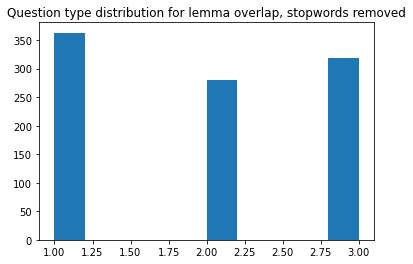

,context_stop_lemmas,sent_stop_lemmas,q_stop_lemmas,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,data
3,"[[egen, företag], [när, ta, emot, ansökan], [o...","[kort, bevis, tillstånd, sverige, innehålla, b...",[uppehållstillståndskort],2,3,[uppehållstillståndskort],[],"(8, 7, 10)","{8: {'sentence_words': ['kort', 'bevis', 'till..."
4,"[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[kort, bevis, tillstånd, sverige, innehålla, b...",[uppehållstillståndskort],2,5,[uppehållstillståndskort],[],"(8, 7, 10, 12, 20)","{8: {'sentence_words': ['kort', 'bevis', 'till..."
5,"[[uppehållstillstånd, medborgare, Schweiz], [s...","[kort, bevis, tillstånd, sverige, innehålla, b...",[uppehållstillståndskort],2,3,[uppehållstillståndskort],[],"(16, 15, 18)","{16: {'sentence_words': ['kort', 'bevis', 'til..."
7,"[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[kort, bevis, tillstånd, sverige, innehålla, b...","[innehålla, uppehållstillståndskort]",2,5,[uppehållstillståndskort],[],"(8, 7, 10, 12, 20)","{8: {'sentence_words': ['kort', 'bevis', 'till..."
8,"[[besöka, Sverige, religiös, syfte], [du, få, ...","[skola, därför, fotograferad, lämna, fingeravt...","[innehålla, uppehållstillståndskort]",2,4,"[innehålla, uppehållstillståndskort]",[],"(15, 12, 13, 14)","{15: {'sentence_words': ['skola', 'därför', 'f..."


In [72]:
# lemma overlap with stopwords removed
all_relevant_sentences_lemma_stop, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, True, True)
df_lemma_stop = pd.DataFrame(all_relevant_sentences_lemma_stop)

df_class_1 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 1]
df_class_2 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 2]
df_class_3 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 3]

plt.hist(df_lemma_stop['overlap_class'].values)
plt.title('Question type distribution for lemma overlap, stopwords removed')
plt.show()

df_class_2.head()

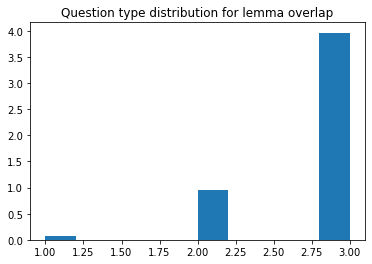

,context_lemmas,sent_lemmas,q_lemmas,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,data
1,"[[egen, företag], [efter, beslut, skicka, till...","[när, du, skola, hämta, beslut, ta, med, pass]","[vad, skola, du, ta, med, när, hämta, beslut]",3,16,[vad],[vad],"(2, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 1...","{2: {'sentence_words': ['när', 'du', 'skola', ..."
3,"[[egen, företag], [när, vi, ha, ta, emot, du, ...","[kort, vara, en, bevis, på, att, du, ha, tills...","[vad, vara, en, uppehållstillståndskort]",3,8,"[vad, uppehållstillståndskort]",[vad],"(8, 2, 7, 10, 11, 13, 17, 20)","{8: {'sentence_words': ['kort', 'vara', 'en', ..."
4,"[[flytta, tillbaka, till, Sverige], [så, ansök...","[kort, vara, en, bevis, på, att, du, ha, tills...","[vad, vara, en, uppehållstillståndskort]",3,12,"[vad, uppehållstillståndskort]",[vad],"(8, 2, 3, 7, 9, 10, 12, 13, 15, 17, 18, 20)","{8: {'sentence_words': ['kort', 'vara', 'en', ..."
5,"[[uppehållstillstånd, för, medborgare, i, Schw...","[kort, vara, en, bevis, på, att, du, ha, tills...","[vad, vara, en, uppehållstillståndskort]",3,8,"[vad, uppehållstillståndskort]",[vad],"(16, 3, 6, 9, 11, 14, 15, 18)","{16: {'sentence_words': ['kort', 'vara', 'en',..."
6,"[[avsla, på, ansökan, om, asyl, stöd, vid, åte...","[om, du, inte, lämna, sverige, inom, en, tid, ...","[vad, innebära, en, återreseförbud]",3,11,[vad],[vad],"(11, 1, 7, 8, 9, 12, 13, 14, 16, 18, 19)","{11: {'sentence_words': ['om', 'du', 'inte', '..."


In [73]:
# lemma overlap with stopwords removed
all_relevant_sentences_lemma, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, False, True)
df_lemma = pd.DataFrame(all_relevant_sentences_lemma)

df_class_1 = df_lemma.loc[df_lemma['overlap_class'] == 1]
df_class_2 = df_lemma.loc[df_lemma['overlap_class'] == 2]
df_class_3 = df_lemma.loc[df_lemma['overlap_class'] == 3]

plt.hist(df_lemma['overlap_class'].values, density=True)
plt.title('Question type distribution for lemma overlap')
plt.show()
df_class_3.head()